**Golf score and head-to-head predictions**

Use of historical golf scoring data for predictive analysis: 
- Build predictive models for professional golf (US PGA & European Tour) events using privately curated datasets with features engineered to represent form going into a contest

Golf is a very difficult sport to make predictions on due to a number of factors:
- **Large number of players:** Field sizes vary from 30-156 players per event
- **Weather:** Sun, wind and rain all play a big role in scoring.  Tournaments are played over 4 days with the weather constantly changing 
- **Variety of course setups:** Links / parkland / length / grass types / rough length / green speed etc.
- **Variety of locations:** Tournaments are played all over the world with different climates and conditions affecting players differently
- **Player form:** All professional players go through several peaks and troughs in their career.  These are very difficult to predict and a professional golfer can go from hero-to-zero and visa versa for no apparent reason
- **Luck:** The bounce of the ball can play a large roll in outcomes

As such, success rates of predictions are low relative to predictions in other sports, e.g. in Football, Tennis, Horse Racing etc.  This is reflected by the high odds that one can get from bookmakers - favorites typically come in around 6-12/1, midrange players around 20-80/1 and the rest can vary from 100-1000/1

- Goal:

Make score and head-to-head predictions using the latest ML & AI techniques.  These will be baselined against historical odds betting data to determine whether or not models can match / beat experts.

- Inspiration:

https://www.bloomberg.com/news/features/2018-05-03/the-gambler-who-cracked-the-horse-racing-code

https://www.bloomberg.com/news/videos/2020-01-09/the-man-who-beat-horse-racing-and-made-close-to-a-billion-dollars-video


**PGA Round-1: 3-ball head-to-head winner prediction:**




In [ ]:
#!pip install -U matplotlib

In [ ]:
import pandas as pd
import numpy as np
import sys, os

run_colab=1

file_name = 'PGA_R1_3b_classification.csv'
init_file_name = 'PGA_R1_3b_classification - Initial.csv'
tour_ind = ['PGA']
r_ind = [1]
g_ind = [3]


m_ho = 100
split = 0.15
k_fold = 10

if run_colab==1:
  from google.colab import drive
  drive.mount('/content/drive')
  data = pd.read_csv('/content/drive/MyDrive/ML_Golf_Betting/GitHub/'+file_name)
else:
  data = pd.read_csv(file_name)

base_cols = list(data.columns)
print(f'({data.shape}) {base_cols}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
((5184, 321)) ['Year_c', 'Month_c', 'Day_c', 'tName_c', 'date_ind', 'pod_id', 'pod_pls', 'pl_back', 'pl_lay', 'm_c', 'DSLT', 'Length_n', 'Length_sg1', 'Length_sg2', 'Length_sg3', 'Length_sg4', 'Length_sgT', 'Length_n_1st_grp', 'Length_n_2nd_grp', 'Length_n_3rd_grp', 'Length_n_4th_grp', 'Length_n_5th_grp', 'Length_n_6th_grp', 'Length_n_7th_grp', 'Length_n_8th_grp', 'Length_n_9th_grp', 'Length_n_10th_grp', 'Length_n_W', 'Ptype_n', 'Ptype_sg1', 'Ptype_sg2', 'Ptype_sg3', 'Ptype_sg4', 'Ptype_sgT', 'Ptype_n_1st_grp', 'Ptype_n_2nd_grp', 'Ptype_n_3rd_grp', 'Ptype_n_4th_grp', 'Ptype_n_5th_grp', 'Ptype_n_6th_grp', 'Ptype_n_7th_grp', 'Ptype_n_8th_grp', 'Ptype_n_9th_grp', 'Ptype_n_10th_grp', 'Ptype_n_W', 'Region_n', 'Region_sg1', 'Region_sg2', 'Region_sg3', 'Region_sg4', 'Region_sgT', 'Region_n_1st_grp', 'Region_n_2nd_grp', 'Region_n_3rd_grp', 'Region_n_4th_grp', 'Region

In [ ]:
print(data.shape)
data.head(3)

(5184, 321)


,Year_c,Month_c,Day_c,tName_c,date_ind,pod_id,pod_pls,pl_back,pl_lay,m_c,DSLT,Length_n,Length_sg1,Length_sg2,Length_sg3,Length_sg4,Length_sgT,Length_n_1st_grp,Length_n_2nd_grp,Length_n_3rd_grp,Length_n_4th_grp,Length_n_5th_grp,Length_n_6th_grp,Length_n_7th_grp,Length_n_8th_grp,Length_n_9th_grp,Length_n_10th_grp,Length_n_W,Ptype_n,Ptype_sg1,Ptype_sg2,Ptype_sg3,Ptype_sg4,Ptype_sgT,Ptype_n_1st_grp,Ptype_n_2nd_grp,Ptype_n_3rd_grp,Ptype_n_4th_grp,Ptype_n_5th_grp,Ptype_n_6th_grp,...,tb3_pT,tb3_fng,tb3_R4_ld_def,dslt_3,tb2_sg1,tb2_p1,tb2_R1_ld_def,tb2_sg2,tb2_p2,tb2_R2_ld_def,tb2_sg3,tb2_p3,tb2_R3_ld_def,tb2_sg4,tb2_sgT,tb2_pT,tb2_fng,tb2_R4_ld_def,dslt_2,tb1_sg1,tb1_p1,tb1_R1_ld_def,tb1_sg2,tb1_p2,tb1_R2_ld_def,tb1_sg3,tb1_p3,tb1_R3_ld_def,tb1_sg4,tb1_sgT,tb1_pT,tb1_fng,tb1_R4_ld_def,dslt_1,R_scr,win_ind,fav_ind,mid_ind,weak_ind,tie_flag
0,2018,8,16,Wyndham Championship (USA),2018_8_16,2018_8_16_v0_d1_grp3_PGA,martin laird,3.00,3.10,156,21,49,0.500395,1.061751,0.276920,0.614095,1.721298,12,4,2,6,6,3,11,3,1,1,0,15,0.116742,0.273147,-0.508063,-0.082754,-1.021118,1,1,0,4,1,3,...,83,6,-30,7,-3.225806,138,-9,2.503226,83,-11,0.000000,83,-30,0.000000,0.000000,83,5,-30,14,-0.627451,84,-8,-0.176471,91,-11,0.000000,96,-30,0.000000,0.000000,96,6,-30,14,-1,0,0,1,0,0
1,2018,8,16,Wyndham Championship (USA),2018_8_16,2018_8_16_v0_d1_grp3_PGA,dominic bozzelli,4.30,4.50,156,21,33,0.597301,-0.612712,-1.271633,0.493631,-0.271742,4,3,4,2,3,4,2,2,4,5,0,14,-0.186262,0.276681,-2.453103,0.610851,-2.428633,2,0,1,2,1,4,...,93,5,-30,7,-0.503448,78,-8,4.841379,16,-8,-2.012195,39,-15,3.253521,1.605634,23,1,-14,7,3.372549,10,-4,-0.176471,37,-7,-0.653846,43,-10,-3.102564,-4.230769,65,4,-17,14,-2,1,0,0,1,2
2,2018,8,16,Wyndham Championship (USA),2018_8_16,2018_8_16_v0_d1_grp3_PGA,joaquin niemann,2.26,2.32,156,7,10,2.418110,0.830319,-0.456339,2.962745,3.780236,4,3,1,0,0,0,1,0,1,0,0,6,2.807405,0.026444,-1.916502,3.297907,1.735927,2,2,0,0,1,0,...,23,1,-14,7,3.372549,10,-4,3.823529,6,-3,-1.653846,21,-7,-2.102564,-0.230769,37,2,-13,14,3.380645,16,-4,-1.406452,49,-9,-1.500000,63,-12,-2.662500,-5.837500,71,4,-18,14,-2,1,1,0,0,2


In [ ]:
data.isna().sum()

Year_c      0
Month_c     0
Day_c       0
tName_c     0
date_ind    0
           ..
win_ind     0
fav_ind     0
mid_ind     0
weak_ind    0
tie_flag    0
Length: 321, dtype: int64

In [ ]:
data.nunique()

Year_c        5
Month_c      12
Day_c        31
tName_c      77
date_ind    136
           ... 
win_ind       2
fav_ind       2
mid_ind       2
weak_ind      2
tie_flag      3
Length: 321, dtype: int64

In [ ]:
data.describe().iloc[:,-10:-5]

,tb1_pT,tb1_fng,tb1_R4_ld_def,dslt_1,R_scr
count,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000
mean,51.054398,3.457369,-16.478781,25.888310,0.139468
std,41.394361,2.930495,10.320801,86.124522,3.616002
min,0.000000,0.000000,-38.000000,0.000000,-11.000000
25%,15.000000,1.000000,-30.000000,7.000000,-2.000000
50%,41.000000,3.000000,-14.000000,14.000000,0.000000
75%,83.000000,6.000000,-8.000000,21.000000,2.000000
max,156.000000,9.000000,11.000000,2436.000000,22.000000


In [ ]:
# number of groups with favourite, mid and weak player identified based on bookies odds (when available)
m_grp_with_p012 = len(data)/ 3 
#Calculate win percentages for bookies favourite, mid and weakest players
fav_w = data.loc[(data['fav_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012
mid_w = data.loc[(data['mid_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012
weak_w = data.loc[(data['weak_ind']==1) & (data['win_ind']==1)].shape[0] / m_grp_with_p012


print('Win percentages for bookies favourite, mid and weakest players [Precision : TP / predicted yes(TP+FP)]')
print(f'fav_w={round(fav_w,4)}, mid_w={round(mid_w,4)}, weak_w={round(weak_w,4)} across {m_grp_with_p012} groups (*including ties)')

Win percentages for bookies favourite, mid and weakest players [Precision : TP / predicted yes(TP+FP)]
fav_w=0.4902, mid_w=0.3669, weak_w=0.2986 across 1728.0 groups (*including ties)


In [ ]:
#Drop groups without favourite, mid and weak player identified
data_with_p012 = data.copy()

In [ ]:
#Flatten each group (currently represented by 3 rows per group) to into a single row per group
tourn_cols = list(data_with_p012.columns[:5])
pl_col = data_with_p012.columns[6]
x_cols = list(data_with_p012.columns[7:-6])
y_cols = list(data_with_p012.columns[-6:])
pl_id = ['p0','p1','p2'] #tags to id players (fav, mid, weak)
p0_cols, p1_cols, p2_cols = [],[],[]
p012_cols = None
y_dict={0:[1,0,0], 1:[0,1,0], 2:[0,0,1], 3:[1,1,0], 4:[1,0,1], 5:[0,1,1], 6:[1,1,1]}

df_flat = pd.DataFrame({'pod_id':list(data_with_p012['pod_id'].unique())})
for i in range(len(df_flat)):
#for i in [0]:
    if i==0: #initialize all columns
        for c in tourn_cols: df_flat[c]=[None]*len(df_flat)
        for pl in pl_id: 
          df_flat[pl+'_'+pl_col]=[None]*len(df_flat)
          if pl=='p0':p0_cols.append(pl+'_'+pl_col)
          if pl=='p1':p1_cols.append(pl+'_'+pl_col)
          if pl=='p2':p2_cols.append(pl+'_'+pl_col)    
        for pl in pl_id:
            for x in x_cols: 
              df_flat[pl+'_'+x]=[None]*len(df_flat)
              if pl=='p0':p0_cols.append(pl+'_'+x)
              if pl=='p1':p1_cols.append(pl+'_'+x)
              if pl=='p2':p2_cols.append(pl+'_'+x)
        for pl in pl_id:
            for y in y_cols: 
              df_flat[pl+'_'+y]=[None]*len(df_flat)
              if pl=='p0':p0_cols.append(pl+'_'+y)
              if pl=='p1':p1_cols.append(pl+'_'+y)
              if pl=='p2':p2_cols.append(pl+'_'+y)
        df_flat['y_target']=[None]*len(df_flat)

        p012_cols=[p0_cols, p1_cols, p2_cols]
        X_features = p0_cols[1:-6]+p1_cols[1:-6]+p2_cols[1:-6]
        Y_classes = [p0_cols[-5], p1_cols[-5], p2_cols[-5]]

    #Populate df_flat
    temp_df = data_with_p012[data_with_p012['pod_id']==df_flat.loc[i,'pod_id']].reset_index()
    df_flat.loc[i,tourn_cols] = temp_df.loc[0,tourn_cols]
    #get fav, mid & weak inds
    p0_ind = temp_df.loc[temp_df['fav_ind']==1].index[0]
    p1_ind = temp_df.loc[temp_df['mid_ind']==1].index[0]
    p2_ind = temp_df.loc[temp_df['weak_ind']==1].index[0]
    p012_ind=[p0_ind, p1_ind, p2_ind]
    for j in range(len(pl_id)):
      df_flat.loc[i,p012_cols[j][0]] = temp_df.loc[p012_ind[j],'pod_pls']
      df_flat.loc[i,p012_cols[j][1:-6]] = temp_df.loc[p012_ind[j],x_cols].values
      df_flat.loc[i,p012_cols[j][-6:]] = temp_df.loc[p012_ind[j],y_cols].values
    #Calculate y_target
    win_lst = list(df_flat.loc[i,Y_classes])
    if [1,0,0]==win_lst: df_flat.loc[i,'y_target']=0
    if [0,1,0]==win_lst: df_flat.loc[i,'y_target']=1
    if [0,0,1]==win_lst: df_flat.loc[i,'y_target']=2
    if [1,1,0]==win_lst: df_flat.loc[i,'y_target']=3
    if [1,0,1]==win_lst: df_flat.loc[i,'y_target']=4
    if [0,1,1]==win_lst: df_flat.loc[i,'y_target']=5
    if [1,1,1]==win_lst: df_flat.loc[i,'y_target']=6

print(df_flat.columns)
print(df_flat.shape)
print(f'{len(p0_cols)}, {len(p1_cols)}, {len(p2_cols)}')

Index(['pod_id', 'Year_c', 'Month_c', 'Day_c', 'tName_c', 'date_ind',
       'p0_pod_pls', 'p1_pod_pls', 'p2_pod_pls', 'p0_pl_back',
       ...
       'p1_mid_ind', 'p1_weak_ind', 'p1_tie_flag', 'p2_R_scr', 'p2_win_ind',
       'p2_fav_ind', 'p2_mid_ind', 'p2_weak_ind', 'p2_tie_flag', 'y_target'],
      dtype='object', length=952)
(1728, 952)
315, 315, 315


In [ ]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

In [ ]:
#Check if multiple favourites (players with tied starting odds) occur in any groups
#If they do (equal_df.shape>0) investigate to see whether fav_w percentage should be ammened and if so by how much 
equal_df = df_flat.loc[df_flat['p0_pl_back']==df_flat['p1_pl_back'], ['pod_id', 'p0_pl_back', 'p1_pl_back', 'p0_win_ind', 'p1_win_ind', 'p2_win_ind']]
equal_df.shape

(0, 6)

In [ ]:
df_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Columns: 952 entries, pod_id to y_target
dtypes: object(952)
memory usage: 12.6+ MB


In [ ]:
df_flat.isnull().values.any()

False

In [ ]:
if run_colab==1:
    os.chdir('/content/drive/MyDrive/ML_Golf_Betting/GitHub/')
df_flat.to_csv('temp_flat.csv', index=False) 

In [ ]:
df_flat.head(3)

,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_sg4,p2_tb2_sgT,p2_tb2_pT,p2_tb2_fng,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
0,2018_8_16_v0_d1_grp3_PGA,2018,8,16,Wyndham Championship (USA),2018_8_16,joaquin niemann,martin laird,dominic bozzelli,2.26,2.32,156,7,10,2.41811,0.830319,-0.456339,2.96275,3.78024,4,3,1,0,0,0,1,0,1,0,0,6,2.8074,0.0264439,-1.9165,3.29791,1.73593,2,2,0,0,...,3.25352,1.60563,23,1,-14,7,3.37255,10,-4,-0.176471,37,-7,-0.653846,43,-10,-3.10256,-4.23077,65,4,-17,14,-2,1,1,0,0,2,-1,0,0,1,0,0,-2,1,0,0,1,2,4
1,2018_4_5_v0_d1_grp7_PGA,2018,4,5,Masters Tournament (USA),2018_4_5,kiradech aphibarnrat,pat perez,francesco molinari,2.86,2.92,87,21,36,1.16297,0.934169,-0.0284728,0.0512733,1.66097,9,5,1,3,5,2,4,6,1,0,0,33,1.0988,0.66787,-0.51631,0.148441,0.536328,7,5,1,2,...,2.25,2.39062,25,3,-11,14,0.201681,48,-8,1.05882,38,-10,2.25974,28,-8,0.454545,1.46753,26,2,-14,14,7,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,2
2,2017_10_19_v0_d1_grp2_PGA,2017,10,19,THE CJ CUP @ NINE BRIDGES (South Korea) - Play...,2017_10_19,justin thomas,pat perez,sangmoon bae,1.9,2.06,78,7,8,1.58776,2.85042,1.46788,3.35514,10.2722,5,0,1,0,0,1,0,0,1,0,2,27,0.557688,1.52352,0.841507,2.05607,4.65262,10,2,3,2,...,0.392857,-2.5,18,5,-13,7,-1.16197,87,-8,-3.96479,121,-17,0,128,-30,0,0,128,8,-30,742,-9,1,1,0,0,0,-3,0,0,1,0,0,-1,0,0,0,1,0,0


In [ ]:
#Veracity Check Data
grp_id = '2018_8_16_v0_d1_grp3_PGA'
#grp_id = '2021_10_21_v0_d1_grp9_PGA'
print(data_with_p012.loc[data_with_p012['pod_id']==grp_id, ['pod_pls','pl_back','Length_sg1','tb12_p1','R_scr', 'win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p0_pod_pls','p0_pl_back','p0_Length_sg1','p0_tb12_p1','p0_R_scr', 'p0_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p1_pod_pls','p1_pl_back','p1_Length_sg1','p1_tb12_p1','p1_R_scr', 'p1_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, ['p2_pod_pls','p2_pl_back','p2_Length_sg1','p2_tb12_p1','p2_R_scr', 'p2_win_ind']])
print()
print(df_flat.loc[df_flat['pod_id']==grp_id, 'y_target'])

            pod_pls  pl_back  Length_sg1  tb12_p1  R_scr  win_ind
0      martin laird     3.00    0.500395      102     -1        0
1  dominic bozzelli     4.30    0.597301      115     -2        1
2   joaquin niemann     2.26    2.418110       62     -2        1

        p0_pod_pls p0_pl_back p0_Length_sg1 p0_tb12_p1 p0_R_scr p0_win_ind
0  joaquin niemann       2.26       2.41811         62       -2          1

     p1_pod_pls p1_pl_back p1_Length_sg1 p1_tb12_p1 p1_R_scr p1_win_ind
0  martin laird          3      0.500395        102       -1          0

         p2_pod_pls p2_pl_back p2_Length_sg1 p2_tb12_p1 p2_R_scr p2_win_ind
0  dominic bozzelli        4.3      0.597301        115       -2          1

0    4
Name: y_target, dtype: object


In [ ]:
#Generate datasets for 3-way data splits
# 1) ho_data
ho_data = df_flat.iloc[-m_ho:].copy()
ho_data.reset_index(inplace=True)
ho_data.drop('index', axis=1, inplace=True)
#Generate X & Y Dataframes
X_ho_df = ho_data.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_ho_df = ho_data.loc[:,'y_target']     # y_target for p012
Y_ho_df_oh = ho_data.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_ho_df={type(X_ho_df)}, {X_ho_df.shape}, {X_ho_df.values[0,0:5]}')
print(f'Y_ho_df={type(Y_ho_df.values)}, {Y_ho_df.shape}, {Y_ho_df.values[0]}')
print(f'Y_ho_df_oh={type(Y_ho_df_oh.values)}, {Y_ho_df_oh.shape}, {Y_ho_df_oh.values[0]}')
#
print(ho_data.shape)
ho_data.head(1)

X_ho_df=<class 'pandas.core.frame.DataFrame'>, (100, 924), [2.4 2.56 156 14 17]
Y_ho_df=<class 'numpy.ndarray'>, (100,), 1
Y_ho_df_oh=<class 'numpy.ndarray'>, (100, 3), [0 1 0]
(100, 952)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_sg4,p2_tb2_sgT,p2_tb2_pT,p2_tb2_fng,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
0,2021_6_17_v0_d1_grp35_PGA,2021,6,17,US Open (USA),2021_6_17,patrick cantlay,louis oosthuizen,sungjae im,2.4,2.56,156,14,17,0.579681,1.69592,1.26057,1.29734,3.58251,5,3,5,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,78,6,-30,7,-3.46622,124,-11,5.02703,53,-12,-0.529412,52,-15,2.95588,-0.352941,35,2,-8,7,-1,0,1,0,0,0,-4,1,0,1,0,0,1,0,0,0,1,0,1


In [ ]:
#Generate datasets for 3-way data splits
# 2) all_data
all_data = df_flat.iloc[:-m_ho].copy()
#Generate X & Y Dataframes
X_all = all_data.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_all = all_data.loc[:,'y_target']     # y_target for p012
Y_all_oh = all_data.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_all={type(X_all)}, {X_all.shape}, {X_all.values[0,0:5]}')
print(f'Y_all={type(Y_all.values)}, {Y_all.shape}, {Y_all.values[0]}')
print(f'Y_all_oh={type(Y_all_oh.values)}, {Y_all_oh.shape}, {Y_all_oh.values[0]}')
#
print(all_data.shape)
all_data.iloc[-1:]

X_all=<class 'pandas.core.frame.DataFrame'>, (1628, 924), [2.26 2.32 156 7 10]
Y_all=<class 'numpy.ndarray'>, (1628,), 4
Y_all_oh=<class 'numpy.ndarray'>, (1628, 3), [1 0 1]
(1628, 952)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_sg4,p2_tb2_sgT,p2_tb2_pT,p2_tb2_fng,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
1627,2021_6_17_v0_d1_grp34_PGA,2021,6,17,US Open (USA),2021_6_17,dustin johnson,rory mcilroy,justin rose,2.6,2.66,156,7,19,1.43838,2.5041,1.01855,1.61758,4.91759,8,4,1,2,0,1,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,...,5.66667,4.69136,8,0,-5,21,2.87395,14,-5,1.42017,16,-7,0.8,17,-10,-0.266667,2.22667,20,1,-10,7,0,0,1,0,0,0,-1,1,0,1,0,0,7,0,0,0,1,0,1


In [ ]:
#Generate datasets for 3-way data splits
# 3) train_primary (used to create train_current & validation_current for k-fold cross-validation)
train_primary = all_data.iloc[:int(len(all_data)*(1-split))].copy()
#Generate X & Y Dataframes
X_train_primary = train_primary.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_train_primary = train_primary.loc[:,'y_target']     # y_target for p012
Y_train_primary_oh = train_primary.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_train_primary={type(X_train_primary)}, {X_train_primary.shape}, {X_train_primary.values[0,0:5]}')
print(f'Y_train_primary={type(Y_train_primary.values)}, {Y_train_primary.shape}, {Y_train_primary.values[0]}')
print(f'Y_train_primary_oh={type(Y_train_primary_oh.values)}, {Y_train_primary_oh.shape}, {Y_train_primary_oh.values[0]}')
#
print(train_primary.shape)
train_primary.iloc[-1:]

X_train_primary=<class 'pandas.core.frame.DataFrame'>, (1383, 924), [2.26 2.32 156 7 10]
Y_train_primary=<class 'numpy.ndarray'>, (1383,), 4
Y_train_primary_oh=<class 'numpy.ndarray'>, (1383, 3), [1 0 1]
(1383, 952)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_sg4,p2_tb2_sgT,p2_tb2_pT,p2_tb2_fng,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
1382,2021_2_11_v0_d1_grp8_PGA,2021,2,11,AT-T Pebble Beach Pro-Am (USA),2021_2_11,will zalatoris,kyle stanley,tom lewis,1.99,2.34,156,7,1,0.953125,1.64844,3.51471,1.32353,3.86765,0,1,0,0,0,0,0,0,0,0,0,3,0.267719,1.45309,2.25778,3.53678,5.54336,2,0,0,0,...,-1.08861,-0.683544,42,2,-13,7,0.363636,50,-7,-1.86364,85,-11,0,93,-30,0,0,93,6,-30,7,-3,0,1,0,0,0,-2,0,0,1,0,0,-6,1,0,0,1,0,2


In [ ]:
#Generate datasets for 3-way data splits
# 4) test_primary
test_primary = all_data.iloc[int(len(all_data)*(1-split)):].copy()
test_primary.reset_index(inplace=True)
test_primary.drop('index', axis=1, inplace=True)
#Generate X & Y Dataframes
X_test_primary = test_primary.loc[:,X_features]     # pl_back_dX -> R1_vFavg for p123
Y_test_primary = test_primary.loc[:,'y_target']     # y_target for p012
Y_test_primary_oh = test_primary.loc[:,Y_classes]   # win_ind_dX for p123
print(f'X_test_primary={type(X_test_primary)}, {X_test_primary.shape}, {X_test_primary.values[0,0:5]}')
print(f'Y_test_primary={type(Y_test_primary.values)}, {Y_test_primary.shape}, {Y_test_primary.values[0]}')
print(f'Y_test_primary_oh={type(Y_test_primary_oh.values)}, {Y_test_primary_oh.shape}, {Y_test_primary_oh.values[0]}')
#
print(test_primary.shape)
test_primary.iloc[-1:]
#test_primary.head(1)

X_test_primary=<class 'pandas.core.frame.DataFrame'>, (245, 924), [2.48 2.5 120 14 23]
Y_test_primary=<class 'numpy.ndarray'>, (245,), 1
Y_test_primary_oh=<class 'numpy.ndarray'>, (245, 3), [0 1 0]
(245, 952)


,pod_id,Year_c,Month_c,Day_c,tName_c,date_ind,p0_pod_pls,p1_pod_pls,p2_pod_pls,p0_pl_back,p0_pl_lay,p0_m_c,p0_DSLT,p0_Length_n,p0_Length_sg1,p0_Length_sg2,p0_Length_sg3,p0_Length_sg4,p0_Length_sgT,p0_Length_n_1st_grp,p0_Length_n_2nd_grp,p0_Length_n_3rd_grp,p0_Length_n_4th_grp,p0_Length_n_5th_grp,p0_Length_n_6th_grp,p0_Length_n_7th_grp,p0_Length_n_8th_grp,p0_Length_n_9th_grp,p0_Length_n_10th_grp,p0_Length_n_W,p0_Ptype_n,p0_Ptype_sg1,p0_Ptype_sg2,p0_Ptype_sg3,p0_Ptype_sg4,p0_Ptype_sgT,p0_Ptype_n_1st_grp,p0_Ptype_n_2nd_grp,p0_Ptype_n_3rd_grp,p0_Ptype_n_4th_grp,...,p2_tb2_sg4,p2_tb2_sgT,p2_tb2_pT,p2_tb2_fng,p2_tb2_R4_ld_def,p2_dslt_2,p2_tb1_sg1,p2_tb1_p1,p2_tb1_R1_ld_def,p2_tb1_sg2,p2_tb1_p2,p2_tb1_R2_ld_def,p2_tb1_sg3,p2_tb1_p3,p2_tb1_R3_ld_def,p2_tb1_sg4,p2_tb1_sgT,p2_tb1_pT,p2_tb1_fng,p2_tb1_R4_ld_def,p2_dslt_1,p0_R_scr,p0_win_ind,p0_fav_ind,p0_mid_ind,p0_weak_ind,p0_tie_flag,p1_R_scr,p1_win_ind,p1_fav_ind,p1_mid_ind,p1_weak_ind,p1_tie_flag,p2_R_scr,p2_win_ind,p2_fav_ind,p2_mid_ind,p2_weak_ind,p2_tie_flag,y_target
244,2021_6_17_v0_d1_grp34_PGA,2021,6,17,US Open (USA),2021_6_17,dustin johnson,rory mcilroy,justin rose,2.6,2.66,156,7,19,1.43838,2.5041,1.01855,1.61758,4.91759,8,4,1,2,0,1,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,...,5.66667,4.69136,8,0,-5,21,2.87395,14,-5,1.42017,16,-7,0.8,17,-10,-0.266667,2.22667,20,1,-10,7,0,0,1,0,0,0,-1,1,0,1,0,0,7,0,0,0,1,0,1


In [ ]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

In [ ]:
#Custom precision calc
def cal_prec(y_true, y_pred):
  prec_scr = 0.0
  pred_array = np.zeros((len(y_pred), 3))
  win_array = np.zeros((len(y_true), 3))
  for h in range(len(pred_array)):
    pred_array[h]=y_dict[y_pred[h]]
    win_array[h]=y_dict[y_true[h]]
  #Calc prec_scr
  for h in range(len(y_pred)):
    bet_won=0
    if y_pred[h]<3: #single winner predicted
      for i in range(pred_array.shape[1]):
          if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              if y_true[h]<3: prec_scr += 1                     #Outright Win
              if y_true[h]>2 and y_true[h]<6: prec_scr += 0.5   #2-way tie
              if y_true[h]==6: prec_scr += 1/3                  #3-way tie
              #print(f'W y_true{win_array[h]}, y_pred{pred_array[h]}, prec_scr={prec_scr}')
    else:  #Multiple winners predicted
      n_win = 0
      n_pred = np.sum(pred_array[h])
      t_scr = 1 / n_pred
      for i in range(pred_array.shape[1]):
        if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              n_win+=1
      if bet_won == 1:
        prec_scr += t_scr*n_win
        #print(f'W y_true{win_array[h]}, y_pred{pred_array[h]}, prec_scr={prec_scr}')
    #if bet_won == 0:
        #print(f'L y_true{win_array[h]}, y_pred{pred_array[h]}, prec_scr={prec_scr}')
  prec = prec_scr / len(y_pred)

  return prec

In [ ]:
#Custom RoR calc
def calc_ror(y_true, y_pred, df, p_res=0):
  odds_array = df[['p0_pl_back','p1_pl_back','p2_pl_back']].values
  stake, prof = 1,0
  pred_array = np.zeros((len(y_pred), 3))
  win_array = np.zeros((len(y_true), 3))
  for h in range(len(pred_array)):
    pred_array[h]=y_dict[y_pred[h]]
    win_array[h]=y_dict[y_true[h]]
  #Calc P&L
  for h in range(len(y_pred)):
    bet_won=0
    temp_id_lst = list(df.loc[h,['p0_pod_pls','p1_pod_pls','p2_pod_pls','pod_id']])
    if y_pred[h]<3: #single winner predicted
      for i in range(pred_array.shape[1]):
          if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              if y_true[h]<3: prof += stake*(odds_array[h,i] - 1)                                     #P/L Outright Win
              if y_true[h]>2 and y_true[h]<6: prof += ((stake/2)*(odds_array[h,i] - 1)) - (stake/2)   #P/L 2-way tie
              if y_true[h]==6: prof += ((stake/3)*(odds_array[h,i] - 1)) - (stake*2/3)                #P/L 3-way tie
              if p_res==1: print(f'W y_true={win_array[h]}, y_pred={pred_array[h]}, prof={prof}, odds={odds_array[h]}, {temp_id_lst}')
    else:  #Multiple winners predicted
      t_prof, n_win = 0,0
      n_pred = np.sum(pred_array[h])
      t_stake = stake / n_pred
      for i in range(pred_array.shape[1]):
        if win_array[h,i] == 1 and pred_array[h,i] == 1:
              bet_won = 1
              n_win+=1
              if y_true[h]<3: t_prof += t_stake*(odds_array[h,i] - 1)                                        #P/L Outright Win
              if y_true[h]>2 and y_true[h]<6: t_prof += ((t_stake/2)*(odds_array[h,i] - 1)) - (t_stake/2)    #P/L 2-way tie
              if y_true[h]==6: t_prof += ((t_stake/3)*(odds_array[h,i] - 1)) - (t_stake*2/3)                 #P/L 3-way tie
      if bet_won == 1:
        prof += t_prof - ((n_pred - n_win)*t_stake)
        if p_res==1: print(f'W y_true={win_array[h]}, y_pred={pred_array[h]}, prof={prof}, odds={odds_array[h]}, {temp_id_lst}')
    if bet_won == 0:
        prof -= stake
        if p_res==1: print(f'L y_true={win_array[h]}, y_pred={pred_array[h]}, prof={prof}, odds={odds_array[h]}, {temp_id_lst}')
  ror = prof / len(y_pred)

  return ror

In [ ]:
# train_val function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as accuracy

def run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, df_init, clf, params, base):
  mod_name=base+'_'+params
  df_res = pd.read_csv('base_res.csv')
  #print(f'\nbase_res = {df_res.shape} {df_res.columns}')
  for i in range(k_fold):
    X_train, X_cv, Y_train, Y_cv, df_init_train, df_init_cv = train_test_split(X_train_primary.copy().values, Y_train_primary.copy().values, df_init.copy(), test_size=adj_split, shuffle=True)
    df_init_train.reset_index(inplace=True)
    df_init_train.drop('index', axis=1, inplace=True)
    df_init_cv.reset_index(inplace=True)
    df_init_cv.drop('index', axis=1, inplace=True)
    print(f'\n[{i}: {mod_name}] {X_train.shape}, {X_cv.shape}, {Y_train.shape}, {Y_cv.shape}, {df_init_train.shape}, {df_init_cv.shape}, {type(X_train)}, {type(Y_train)}, {type(df_init_train)}')
    print('df_init_train[0]='+str(df_init_train.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_train[0]='+str(Y_train[0])+', X_train[0,0]='+str(X_train[0,0])+
          ', df_init_cv[0]='+str(df_init_cv.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_cv[0]='+str(Y_cv[0])+', X_cv[0,0]='+str(X_cv[0,0]))
    # Normalize data
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)   
    X_cv_norm = scaler.transform(X_cv)
    # Fit model & predict
    model = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_train = model.predict(X_train_norm)
    pred_cv = model.predict(X_cv_norm)
    # Update df_res with results
    df_res = df_res.append(pd.Series(), ignore_index=True)
    row_ind = len(df_res)-1
    df_res.loc[row_ind,'model']=base
    df_res.loc[row_ind,'params']=params
    df_res.loc[row_ind,'m_train']=len(X_train)
    df_res.loc[row_ind,'m_cv']=len(X_cv)
    df_res.loc[row_ind,'pred_ror_train']=calc_ror(Y_train.astype('int'), pred_train, df_init_train)
    df_res.loc[row_ind,'pred_ror_cv']=calc_ror(Y_cv.astype('int'), pred_cv, df_init_cv)
    df_res.loc[row_ind,'fav_ror_train']=calc_ror(Y_train.astype('int'), np.zeros((len(pred_train))).astype('int'), df_init_train)
    df_res.loc[row_ind,'fav_ror_cv']=calc_ror(Y_cv.astype('int'), np.zeros((len(pred_cv))).astype('int'), df_init_cv)
    df_res.loc[row_ind,'pred_prec_train']=cal_prec(Y_train.astype('int'), pred_train)
    df_res.loc[row_ind,'pred_prec_cv']=cal_prec(Y_cv.astype('int'), pred_cv)
    df_res.loc[row_ind,'fav_prec_train']=cal_prec(Y_train.astype('int'), np.zeros((len(pred_train))))
    df_res.loc[row_ind,'fav_prec_cv']=cal_prec(Y_cv.astype('int'), np.zeros((len(pred_cv))))
    df_res.loc[row_ind,'acc_train']=accuracy(Y_train.astype('int'), pred_train)
    df_res.loc[row_ind,'acc_cv']=accuracy(Y_cv.astype('int'), pred_cv)
    df_res.loc[row_ind,'p0_freq_train']=(pred_train==0).sum()/len(pred_train)
    df_res.loc[row_ind,'p0_freq_cv']=(pred_cv==0).sum()/len(pred_cv)
    print('\n'+str(df_res.iloc[row_ind]))

  return df_res, mod_name

In [ ]:
# Update results_df function
def update_df(df_results, mod_results, mod_name, params, red_col):
  if not(mod_name in list(df_results['model'])):
    df_results = df_results.append(pd.Series(), ignore_index=True)
    row_ind = len(df_results)-1
  else: 
    row_ind = df_results.index[df_results['model']==mod_name].values[0]
    df_results.iloc[row_ind]=None
  #Update df_results
  df_results.loc[row_ind,'model']=mod_name
  df_results.loc[row_ind,'params']=params
  df_results.loc[row_ind,'m_train']=mod_results['m_train'].mean()
  df_results.loc[row_ind,'m_cv']=mod_results['m_cv'].mean()
  df_results.loc[row_ind,'pred_ror_train']=mod_results['pred_ror_train'].mean()
  df_results.loc[row_ind,'pred_ror_cv']=mod_results['pred_ror_cv'].mean()
  df_results.loc[row_ind,'fav_ror_train']=mod_results['fav_ror_train'].mean()
  df_results.loc[row_ind,'fav_ror_cv']=mod_results['fav_ror_cv'].mean()
  df_results.loc[row_ind,'pred_prec_train']=mod_results['pred_prec_train'].mean()
  df_results.loc[row_ind,'pred_prec_cv']=mod_results['pred_prec_cv'].mean()
  df_results.loc[row_ind,'fav_prec_train']=mod_results['fav_prec_train'].mean()
  df_results.loc[row_ind,'fav_prec_cv']=mod_results['fav_prec_cv'].mean()
  df_results.loc[row_ind,'acc_train']=mod_results['acc_train'].mean()
  df_results.loc[row_ind,'acc_cv']=mod_results['acc_cv'].mean()
  df_results.loc[row_ind,'p0_freq_train']=mod_results['p0_freq_train'].mean()
  df_results.loc[row_ind,'p0_freq_cv']=mod_results['p0_freq_cv'].mean()
  df_results.loc[row_ind,'stdev_pred_ror_train']=mod_results['pred_ror_train'].std()
  df_results.loc[row_ind,'stdev_pred_ror_cv']=mod_results['pred_ror_cv'].std()
  df_results.loc[row_ind,'reduced_cols']=str(red_col)
  print('\ndf_results-'+str(row_ind)+'-'+str(df_results.iloc[row_ind]))

  return df_results

## **1) Evaluate using ALL Features**

In [ ]:
#Evaluate models using all features
res_file = tour_ind[0]+'_R'+str(r_ind[0])+'_'+str(g_ind[0])+'b_model_results.csv'
df_results = pd.read_csv(res_file)
print(f'df_results = {df_results.shape} {df_results.columns}')
adj_split = len(test_primary)/len(train_primary)

reduced_cols = X_features
##Model A)
ev = 0
if ev==1:
  from sklearn.svm import LinearSVC
  base = 'SVM LinearSVC_all'
  for cl in ['ovr']:                                                            #, 'crammer_singer']:
    #for c in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]:                   #,50, 100, 500, 1000]:
    #for c in np.logspace(-3, 1, 100):
    for c in np.random.uniform(0,10,1000):
      params = cl+'_'+str(c)
      print(f'\nRunning {base} with hyperparameters {params}...')
      clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
      mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
      df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
  try: df_results.drop('Unnamed: 0', inplace=True)
  except KeyError: None 
  df_results.to_csv(res_file, index=False)

##Model B)
ev = 0
if ev==1:
  from sklearn.ensemble import RandomForestClassifier
  base = 'RandomForestClassifier_all'
  for ne in [100, 300]:                     #, 500, 800, 1200]:
    for md in [None, 2, 5, 8, 15, 25, 30]:
      for mss in [2, 5, 10, 15, 100]:
        for msl in [1, 2, 5, 10]:
          for bs in [True,False]:
            params = str(ne)+'_'+str(md)+'_'+str(mss)+'_'+str(msl)+'_'+str(bs)
            print(f'\nRunning {base} with hyperparameters {params}...')
            clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
            mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
            df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
  try: df_results.drop('Unnamed: 0', inplace=True)
  except KeyError: None 
  df_results.to_csv(res_file, index=False)

##Model C)
ev = 0
if ev==1:
  from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

  r_g=1
  if r_g==1:
    base = 'GaussianNB_all'
    for v in np.logspace(0,-9, num=1000):
      params = str(v)
      print(f'\nRunning {base} with hyperparameters {params}...')
      clf = GaussianNB(var_smoothing=v)
      mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
      df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)
  
    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

  r_m=0
  if r_m==1:
    base = 'MultinomialNB'
    params = ''
    print(f'\nRunning {base} with hyperparameters {params}...')
    clf = MultinomialNB()
    mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
    df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

  r_b=1
  if r_b==1:
    base = 'BernoulliNB_all'
    for a in np.random.uniform(0,2,25):
      for b in np.random.uniform(0,2,25):
        for fp in [True, False]:
          params = str(a)+'_'+str(b)+'_'+str(fp)
          print(f'\nRunning {base} with hyperparameters {params}...')
          clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
          mod_results, mod_name = run_train_val(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base)
          df_results = update_df(df_results, mod_results, mod_name, params, reduced_cols)

    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
try: df_results.drop('Unnamed: 0', inplace=True)
except KeyError: None 
df_results.to_csv(res_file, index=False)

df_results = (4552, 36) Index(['model', 'params', 'm_train', 'm_cv', 'm_test', 'm_ho',
       'pred_ror_train', 'pred_ror_cv', 'pred_ror_test', 'pred_ror_ho',
       'fav_ror_train', 'fav_ror_cv', 'fav_ror_test', 'fav_ror_ho',
       'pred_prec_train', 'pred_prec_cv', 'pred_prec_test', 'pred_prec_ho',
       'fav_prec_train', 'fav_prec_cv', 'fav_prec_test', 'fav_prec_ho',
       'acc_train', 'acc_cv', 'acc_test', 'acc_ho', 'p0_freq_train',
       'p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'stdev_pred_ror_train',
       'stdev_pred_ror_cv', 'reduced_cols', 'prod_mod', 'mu', 'sigma'],
      dtype='object')


In [ ]:
df_results.head()

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,"GaussianNB_fs_2.3713737056616552e-06[56, 9, 82...",2.37E-06,1138,245,NaN,NaN,0.050053,0.168189,NaN,NaN,-0.011805,0.052016,NaN,NaN,0.429701,0.468571,NaN,NaN,0.433773,0.457959,NaN,NaN,0.370475,0.417143,NaN,NaN,0.771705,0.772245,NaN,NaN,0.019098,0.084682,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p2_dslt...",NaN,NaN,NaN
1,"SVM LinearSVC_fs_ovr_3.0096985284627342[56, 18...",ovr_3.0096985284627342,1138,245,NaN,NaN,0.060982,0.148246,NaN,NaN,-0.007718,0.033033,NaN,NaN,0.426157,0.456190,NaN,NaN,0.434153,0.456190,NaN,NaN,0.300527,0.316735,NaN,NaN,0.497188,0.493878,NaN,NaN,0.028321,0.055121,"['p0_Region_n_4th_grp', 'p0_tb9_p3', 'p1_tb7_R...",NaN,NaN,NaN
2,"SVM LinearSVC_fs_ovr_0.9987059574068247[56, 18...",ovr_0.9987059574068247,1138,245,NaN,NaN,0.059294,0.134810,NaN,NaN,-0.014642,0.065193,NaN,NaN,0.416579,0.442313,NaN,NaN,0.431576,0.468163,NaN,NaN,0.302812,0.327347,NaN,NaN,0.488752,0.467755,NaN,NaN,0.023551,0.037164,"['p0_Region_n_4th_grp', 'p0_tb9_p3', 'p1_tb7_R...",NaN,NaN,NaN
3,"SVM LinearSVC_fs_ovr_1.6602953166609407[56, 18...",ovr_1.6602953166609407,1138,245,NaN,NaN,0.080769,0.130407,NaN,NaN,-0.002525,0.008914,NaN,NaN,0.424985,0.442313,NaN,NaN,0.436526,0.445170,NaN,NaN,0.317750,0.330612,NaN,NaN,0.513357,0.495510,NaN,NaN,0.040369,0.084009,"['p0_Region_n_4th_grp', 'p0_tb9_p3', 'p1_tb7_R...",NaN,NaN,NaN
4,"GaussianNB_fs_1.7782794100389227e-07[56, 9, 12...",1.78E-07,1138,245,NaN,NaN,0.091486,0.128884,NaN,NaN,-0.007627,0.032611,NaN,NaN,0.441857,0.454014,NaN,NaN,0.435530,0.449796,NaN,NaN,0.388928,0.399184,NaN,NaN,0.741125,0.765714,NaN,NaN,0.024720,0.033392,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p0_Gg_i...",NaN,NaN,NaN


In [ ]:
#Best Model when pred_ror_cv is max (based on all features)
df_results['pred_ror_cv'] = pd.to_numeric(df_results['pred_ror_cv'])
temp_df = df_results[df_results['model'].str.contains('_all')].copy()
top_ror_ind = temp_df['pred_ror_cv'].idxmax()
top_ror_mod = df_results.loc[top_ror_ind, 'model']
df_results[df_results['model']==top_ror_mod]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
82,RandomForestClassifier_all_500_30_5_2_True,500_30_5_2_True,1138,245,NaN,NaN,1.64538,0.455646,NaN,NaN,-0.010115,0.044168,NaN,NaN,0.999473,0.455646,NaN,NaN,0.433699,0.458299,NaN,NaN,0.999473,0.397551,NaN,NaN,0.382513,0.965714,NaN,NaN,0.013518,0.043399,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [ ]:
#Best Model when pred_prec_cv is max (based on all features)
df_results['pred_prec_cv'] = pd.to_numeric(df_results['pred_prec_cv'])
temp_df = df_results[df_results['model'].str.contains('_all')].copy()
top_prec_ind = temp_df['pred_prec_cv'].idxmax()
top_prec_mod = df_results.loc[top_prec_ind, 'model']
df_results[df_results['model']==top_prec_mod]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
82,RandomForestClassifier_all_500_30_5_2_True,500_30_5_2_True,1138,245,NaN,NaN,1.64538,0.455646,NaN,NaN,-0.010115,0.044168,NaN,NaN,0.999473,0.455646,NaN,NaN,0.433699,0.458299,NaN,NaN,0.999473,0.397551,NaN,NaN,0.382513,0.965714,NaN,NaN,0.013518,0.043399,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",NaN,NaN,NaN


In [ ]:
'''
Evaluate test data for 1) model with best pred_ror_cv, 2) model with best pred_ror_cv when pred_prec_cv > fav_prec_cv 
Train best model with X_train_primary, Y_train_primary & train_primary
Evaluate on X_test_primary, Y_test_primary, test_primary
'''
#from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

best_mod_ror = 'RandomForestClassifier_all_500_30_5_2_True'
best_mod_prec = 'RandomForestClassifier_all_500_30_5_2_True'

for i in range(1):
  # Set up parameters
  if i==0:
    best_mod = best_mod_ror
    ne,md,mss,msl,bs = 500,30,5,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  if i==1:
    best_mod = best_mod_prec
    ne,md,mss,msl,bs = 500,30,5,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  '''
  Gaussian:
    v=5.336699231206313e-06
    clf = GaussianNB(var_smoothing=v)
  Bernoulli:
    a, b, fp = 1.9000000000000001, 1.25, True
    clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
  RFC:
    ne, md, mss, msl, bs = 500,30,5,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  SVC:
    cl, c = 'ovr',0.004862601580065354
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  '''
  # Define data sets
  X_train, Y_train, df_init_train = X_train_primary.copy().values, Y_train_primary.copy().values, train_primary.copy()
  X_test, Y_test, df_init_test = X_test_primary.copy().values, Y_test_primary.copy().values, test_primary.copy()
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)   
  X_test_norm = scaler.transform(X_test)
  # Fit model & predict
  model = clf.fit(X_train_norm, Y_train.astype('int'))
  pred_test = model.predict(X_test_norm)
  # Update df_res with results
  row_ind = df_results.index[df_results['model']==best_mod].values[0]
  df_results.loc[row_ind,'m_test']=len(X_test)
  df_results.loc[row_ind,'pred_ror_test']=calc_ror(Y_test.astype('int'), pred_test, df_init_test)
  df_results.loc[row_ind,'fav_ror_test']=calc_ror(Y_test.astype('int'), np.zeros((len(pred_test))).astype('int'), df_init_test)
  df_results.loc[row_ind,'pred_prec_test']=cal_prec(Y_test.astype('int'), pred_test)
  df_results.loc[row_ind,'fav_prec_test']=cal_prec(Y_test.astype('int'), np.zeros((len(pred_test))))
  df_results.loc[row_ind,'acc_test']=accuracy(Y_test.astype('int'), pred_test)
  df_results.loc[row_ind,'p0_freq_test']=(pred_test==0).sum()/len(pred_test)
  df_results.to_csv(res_file, index=False)

In [ ]:
'''
Evaluate hold out data for 1) model with best pred_ror_cv, 2) model with best pred_ror_cv when pred_prec_cv > fav_prec_cv
Train best model with X_all, Y_all, all_data
Evaluate on X_ho, Y_ho, ho_data
'''
for i in range(1):
  # Set up parameters
  if i==0:
    best_mod = best_mod_ror
    ne, md, mss, msl, bs = 500,30,5,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  if i==1:
    best_mod = best_mod_prec
    ne, md, mss, msl, bs = 500,30,5,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  '''
  Gaussian:
    v=5.336699231206313e-06
    clf = GaussianNB(var_smoothing=v)
  Bernoulli:
    a, b, fp = 1.9000000000000001, 1.25, True
    clf = BernoulliNB(alpha=a, binarize=b, fit_prior=fp)
  RFC:
    ne, md, mss, msl, bs = 500,30,5,2,True
    clf = RandomForestClassifier(random_state=0, class_weight='balanced', n_estimators=ne, max_depth=md, min_samples_split=mss, min_samples_leaf=msl, bootstrap=bs)
  SVC:
    cl, c = 'ovr',0.004862601580065354
    clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
  '''
  # Define data sets
  X_train, Y_train, df_init_train = X_all.copy().values, Y_all.copy().values, all_data.copy()
  X_ho, Y_ho, df_init_ho = X_ho_df.copy().values, Y_ho_df.copy().values, ho_data.copy()
  # Normalize data
  scaler = StandardScaler()
  X_train_norm = scaler.fit_transform(X_train)   
  X_ho_norm = scaler.transform(X_ho)
  # Fit model & predict
  if i==0: 
    model_ror = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_ho_ror = model_ror.predict(X_ho_norm)
    temp_pred = pred_ho_ror
  if i==1: 
    model_prec = clf.fit(X_train_norm, Y_train.astype('int'))
    pred_ho_prec = model_prec.predict(X_ho_norm)
    temp_pred = pred_ho_prec
  # Update df_res with results
  row_ind = df_results.index[df_results['model']==best_mod].values[0]
  df_results.loc[row_ind,'m_ho']=len(X_ho)
  df_results.loc[row_ind,'pred_ror_ho']=calc_ror(Y_ho.astype('int'), temp_pred, df_init_ho)
  df_results.loc[row_ind,'fav_ror_ho']=calc_ror(Y_ho.astype('int'), np.zeros((len(temp_pred))).astype('int'), df_init_ho)
  df_results.loc[row_ind,'pred_prec_ho']=cal_prec(Y_ho.astype('int'), temp_pred)
  df_results.loc[row_ind,'fav_prec_ho']=cal_prec(Y_ho.astype('int'), np.zeros((len(temp_pred))))
  df_results.loc[row_ind,'acc_ho']=accuracy(Y_ho.astype('int'), temp_pred)
  df_results.loc[row_ind,'p0_freq_ho']=(temp_pred==0).sum()/len(temp_pred)
  df_results.loc[row_ind,'prod_mod']=best_mod
  df_results.loc[row_ind,'mu']=str(list(scaler.mean_))
  df_results.loc[row_ind,'sigma']=str(list(scaler.scale_))
  df_results.to_csv(res_file, index=False)

In [ ]:
# save the model to disk
import pickle
filename_ror = 'ror_PGA_R1_3b_all_data.sav'
pickle.dump(model_ror, open(filename_ror, 'wb'))
filename_prec = 'prec_PGA_R1_3b_all_data.sav'
try: pickle.dump(model_prec, open(filename_prec, 'wb'))
except NameError: None

In [ ]:
df_results.loc[(df_results['model']==best_mod_ror) | (df_results['model']==best_mod_prec)]

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
82,RandomForestClassifier_all_500_30_5_2_True,500_30_5_2_True,1138,245,245.0,100.0,1.64538,0.455646,0.022619,-0.232,-0.010115,0.044168,0.019844,-0.232,0.999473,0.455646,0.457143,0.338333,0.433699,0.458299,0.457143,0.338333,0.999473,0.397551,0.408163,0.29,0.382513,0.965714,0.97551,0.97,0.013518,0.043399,"['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT...",RandomForestClassifier_all_500_30_5_2_True,"[2.3063390663390666, 2.465184275184275, 133.60...","[0.28799674619734594, 0.37120135392820913, 28...."


In [ ]:
# Create bar chart showing model vs fav performance across: 'p0_freq_train','p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'prec_train', 'prec_cv', 'prec_test', 'prec_ho', 'ror_train', 'ror_cv', 'ror_test', 'ror_ho'
if run_colab==1:
    os.chdir('/content/drive/MyDrive/ML_Golf_Betting/GitHub/')
    from charts_v2 import make_bars_all
    %load_ext autoreload
    %autoreload 2
  
from charts_v2 import make_bars_all

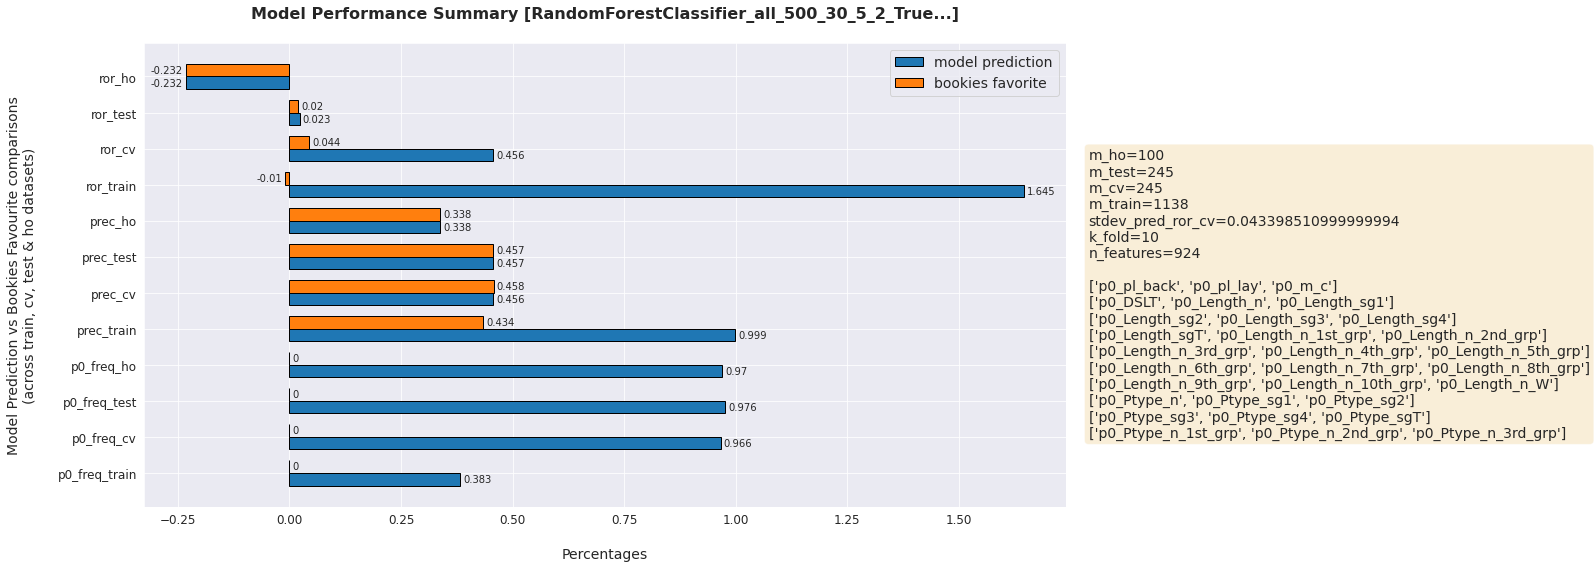

In [ ]:
df_bar = make_bars_all(best_mod_ror, df_results, k_fold)

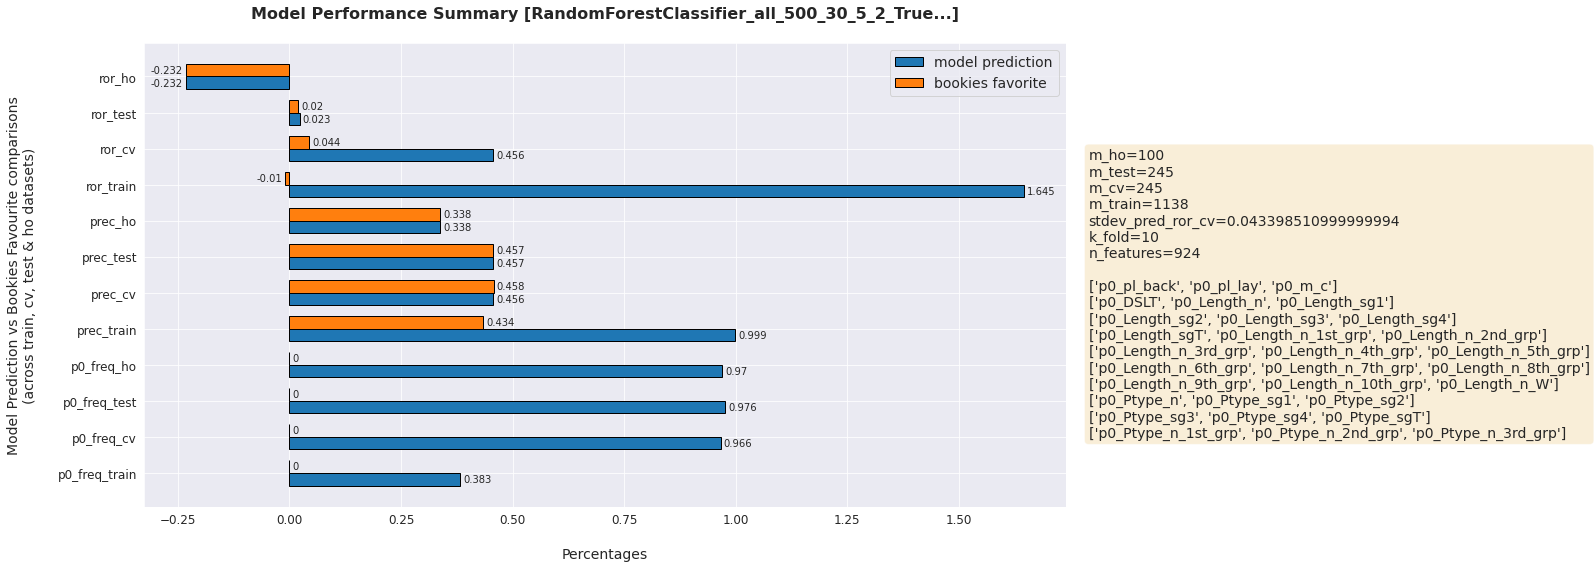

In [ ]:
df_bar = make_bars_all(best_mod_prec, df_results, k_fold)

In [ ]:
#Review ho results from model for all feature model
eval_ror_ho = calc_ror(Y_ho.astype('int'), pred_ho_ror, df_init_ho, p_res=1)
#eval_ror_ho = calc_ror(Y_ho.astype('int'), pred_ho_prec, df_init_ho, p_res=1)
print(f'\neval_ror_ho = {eval_ror_ho}')

L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1, odds=[2.4 2.96 3.65], ['patrick cantlay', 'louis oosthuizen', 'sungjae im', '2021_6_17_v0_d1_grp35_PGA']
W y_true=[1. 1. 0.], y_pred=[1. 0. 0.], prof=-0.8799999999999999, odds=[2.24 3.25 3.7], ['cameron smith', 'matt jones', 'brendan steele', '2021_6_17_v0_d1_grp36_PGA']
L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1.88, odds=[2.68 3.0 3.05], ['charley hoffman', 'kevin streelman', 'branden grace', '2021_6_17_v0_d1_grp37_PGA']
W y_true=[1. 0. 1.], y_pred=[1. 0. 0.], prof=-1.6199999999999999, odds=[2.52 3.0 3.45], ['carlos ortiz', 'lanto griffin', 'zach johnson', '2021_6_17_v0_d1_grp38_PGA']
L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-2.62, odds=[2.26 3.35 3.5], ['sam burns', 'thomas detry', 'chan kim', '2021_6_17_v0_d1_grp39_PGA']
L y_true=[0. 0. 1.], y_pred=[1. 0. 0.], prof=-3.62, odds=[2.66 2.72 3.75], ['brendon todd', 'sebastian munoz', 'rikuya hoshino', '2021_6_17_v0_d1_grp40_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=-2.42

In [ ]:
#Review ho results from loaded model
from sklearn.ensemble import RandomForestClassifier
import ast, pickle

#Load model and normalization parameters
loaded_model = pickle.load(open('ror_PGA_R1_3b_all_data.sav', 'rb'))  #ror_PGA_R1_3b_all_data.sav / prec_PGA_R1_3b_all_data.sav
mu = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='RandomForestClassifier_all_500_30_5_2_True', 'mu'])[0])
sigma = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='RandomForestClassifier_all_500_30_5_2_True', 'sigma'])[0])
X_ho, Y_ho, df_init_ho = X_ho_df.copy().values, Y_ho_df.copy().values, ho_data.copy()
#Normalize data
eval_norm = np.divide(np.subtract(X_ho, mu), sigma)
#Predict from loaded model & evaluate
eval_pred = loaded_model.predict(eval_norm)
eval_ror_loaded = calc_ror(Y_ho.astype('int'), eval_pred, df_init_ho, p_res=1)
try: print(f'\neval_ror_loaded = {eval_ror_loaded} ... eval_ror_ho = {eval_ror_ho}')
except NameError: print(f'\neval_ror_loaded = {eval_ror_loaded}')

L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1, odds=[2.4 2.96 3.65], ['patrick cantlay', 'louis oosthuizen', 'sungjae im', '2021_6_17_v0_d1_grp35_PGA']
W y_true=[1. 1. 0.], y_pred=[1. 0. 0.], prof=-0.8799999999999999, odds=[2.24 3.25 3.7], ['cameron smith', 'matt jones', 'brendan steele', '2021_6_17_v0_d1_grp36_PGA']
L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1.88, odds=[2.68 3.0 3.05], ['charley hoffman', 'kevin streelman', 'branden grace', '2021_6_17_v0_d1_grp37_PGA']
W y_true=[1. 0. 1.], y_pred=[1. 0. 0.], prof=-1.6199999999999999, odds=[2.52 3.0 3.45], ['carlos ortiz', 'lanto griffin', 'zach johnson', '2021_6_17_v0_d1_grp38_PGA']
L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-2.62, odds=[2.26 3.35 3.5], ['sam burns', 'thomas detry', 'chan kim', '2021_6_17_v0_d1_grp39_PGA']
L y_true=[0. 0. 1.], y_pred=[1. 0. 0.], prof=-3.62, odds=[2.66 2.72 3.75], ['brendon todd', 'sebastian munoz', 'rikuya hoshino', '2021_6_17_v0_d1_grp40_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=-2.42

In [ ]:
type(loaded_model)

sklearn.ensemble._forest.RandomForestClassifier

## **2) Evaluate using Forward Feature Selection**

In [ ]:
print(f'X_features = {X_features}')
print(f'Y_classes = {Y_classes}')
print(f'y_dict = {y_dict}')
print(f'x_cols = {x_cols}')
print(f'y_cols = {y_cols}')
print(f'tourn_cols = {tourn_cols}')
print(f'pl_id = {pl_id}')
print(f'pl_col = {pl_col}')
print(f'p012_cols = {p012_cols}')

X_features = ['p0_pl_back', 'p0_pl_lay', 'p0_m_c', 'p0_DSLT', 'p0_Length_n', 'p0_Length_sg1', 'p0_Length_sg2', 'p0_Length_sg3', 'p0_Length_sg4', 'p0_Length_sgT', 'p0_Length_n_1st_grp', 'p0_Length_n_2nd_grp', 'p0_Length_n_3rd_grp', 'p0_Length_n_4th_grp', 'p0_Length_n_5th_grp', 'p0_Length_n_6th_grp', 'p0_Length_n_7th_grp', 'p0_Length_n_8th_grp', 'p0_Length_n_9th_grp', 'p0_Length_n_10th_grp', 'p0_Length_n_W', 'p0_Ptype_n', 'p0_Ptype_sg1', 'p0_Ptype_sg2', 'p0_Ptype_sg3', 'p0_Ptype_sg4', 'p0_Ptype_sgT', 'p0_Ptype_n_1st_grp', 'p0_Ptype_n_2nd_grp', 'p0_Ptype_n_3rd_grp', 'p0_Ptype_n_4th_grp', 'p0_Ptype_n_5th_grp', 'p0_Ptype_n_6th_grp', 'p0_Ptype_n_7th_grp', 'p0_Ptype_n_8th_grp', 'p0_Ptype_n_9th_grp', 'p0_Ptype_n_10th_grp', 'p0_Ptype_n_W', 'p0_Region_n', 'p0_Region_sg1', 'p0_Region_sg2', 'p0_Region_sg3', 'p0_Region_sg4', 'p0_Region_sgT', 'p0_Region_n_1st_grp', 'p0_Region_n_2nd_grp', 'p0_Region_n_3rd_grp', 'p0_Region_n_4th_grp', 'p0_Region_n_5th_grp', 'p0_Region_n_6th_grp', 'p0_Region_n_7th_grp'

Feature ranking:
1. feature 47 [p0_Region_n_4th_grp] (0.002137)
2. feature 0 [p0_pl_back] (0.002068)
3. feature 865 [p2_tb4_p1] (0.002064)
4. feature 113 [p0_Gg_id_sg2] (0.002022)
5. feature 498 [p1_tb8_R1_ld_def] (0.002020)
6. feature 707 [p2_Tier3_n] (0.001965)
7. feature 240 [p0_tb5_p3] (0.001962)
8. feature 818 [p2_dslt_8] (0.001958)
9. feature 591 [p1_tb2_R2_ld_def] (0.001933)
10. feature 669 [p2_Region_n_10th_grp] (0.001925)
11. feature 180 [p0_tb9_p3] (0.001921)
12. feature 130 [p0_tb12_R1_ld_def] (0.001915)
13. feature 741 [p2_Gg_n_9th_grp] (0.001902)
14. feature 259 [p0_tb4_pT] (0.001869)
15. feature 916 [p2_tb1_p3] (0.001863)
16. feature 519 [p1_tb7_R3_ld_def] (0.001860)
17. feature 610 [p1_tb1_sg4] (0.001855)
18. feature 148 [p0_tb11_R2_ld_def] (0.001855)
19. feature 851 [p2_tb5_R1_ld_def] (0.001850)
20. feature 368 [p1_CountryState_sgT] (0.001839)
21. feature 59 [p0_CountryState_sg4] (0.001828)
22. feature 437 [p1_tb12_p1] (0.001827)
23. feature 93 [p0_Tier1_n] (0.001826)
2

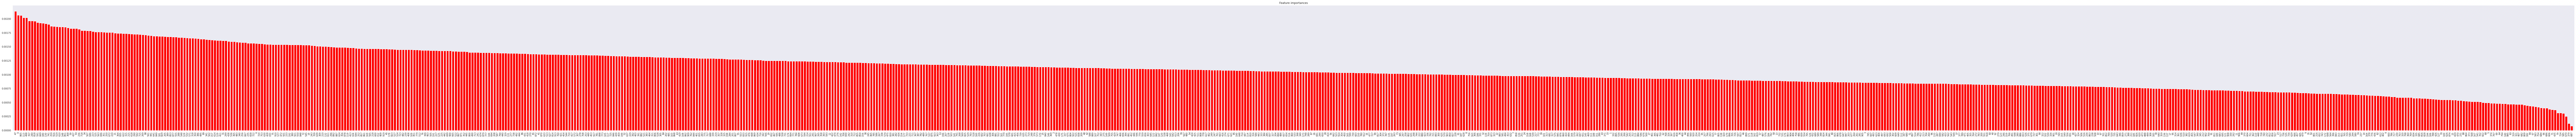

len(ranked_features)=924: ['p0_Region_n_4th_grp', 'p0_pl_back', 'p2_tb4_p1', 'p0_Gg_id_sg2', 'p1_tb8_R1_ld_def', 'p2_Tier3_n', 'p0_tb5_p3', 'p2_dslt_8', 'p1_tb2_R2_ld_def', 'p2_Region_n_10th_grp', 'p0_tb9_p3', 'p0_tb12_R1_ld_def', 'p2_Gg_n_9th_grp', 'p0_tb4_pT', 'p2_tb1_p3', 'p1_tb7_R3_ld_def', 'p1_tb1_sg4', 'p0_tb11_R2_ld_def', 'p2_tb5_R1_ld_def', 'p1_CountryState_sgT', 'p0_CountryState_sg4', 'p1_tb12_p1', 'p0_Tier1_n', 'p0_tb5_sg2', 'p2_Cg_n_3rd_grp', 'p0_Ptype_n_8th_grp', 'p1_tb8_pT', 'p2_Ptype_n_4th_grp', 'p0_tb6_R2_ld_def', 'p1_dslt_7', 'p1_tb4_p3', 'p2_Tier_n_3rd_grp', 'p1_Region_sgT', 'p0_tb4_R1_ld_def', 'p2_CountryState_sg1', 'p0_tb6_R1_ld_def', 'p0_Ptype_n', 'p1_CountryState_sg1', 'p2_tb6_p1', 'p2_Length_sg2', 'p1_Length_sg3', 'p0_tb7_fng', 'p2_m_c', 'p0_tb2_fng', 'p1_tb2_sg3', 'p2_Cg_id_sgT', 'p0_tb3_sg3', 'p0_Cg_id_sg4', 'p1_tb4_R2_ld_def', 'p1_tb12_R2_ld_def', 'p2_Ptype_sg4', 'p2_tb5_sg1', 'p0_tb9_R3_ld_def', 'p2_tb7_sgT', 'p0_tb7_R1_ld_def', 'p1_Tier_n_4th_grp', 'p2_tb5_p2

In [ ]:
from return_feature_rank_from_RF import return_feature_rank_from_RF
from sklearn.preprocessing import StandardScaler

X_train_fs = train_primary.loc[:,X_features].values     # pl_back_dX -> R1_vFavg for p123
Y_train_fs = train_primary.loc[:,'y_target'].values     # y_target for p012
scaler = StandardScaler()
X_train_fs_norm = scaler.fit_transform(X_train_fs) 

indices, importances = return_feature_rank_from_RF(X_train_fs_norm, Y_train_fs.astype('int'), X_features)
ranked_features = []
for x in range(len(X_features)): ranked_features.append(X_features[indices[x]])
print(f'len(ranked_features)={len(ranked_features)}: {ranked_features}')

In [ ]:
# train_val function with feature selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score as accuracy

def run_train_val_fs(k_fold, adj_split, X_train_primary, Y_train_primary, df_init, clf, params, base, red_ror, red_prec):
  params_ror, params_prec = params+str([df_init.columns.get_loc(c) for c in red_ror if c in df_init]), params+str([df_init.columns.get_loc(c) for c in red_prec if c in df_init])
  mod_name_ror, mod_name_prec = base+'_'+params_ror, base+'_'+params_prec
  df_res_ror, df_res_prec = pd.read_csv('base_res.csv'), pd.read_csv('base_res.csv')
  #print(f'\nbase_res = {df_res.shape} {df_res.columns}')
  for i in range(k_fold):
    X_train_ror, X_cv_ror, Y_train, Y_cv, df_init_train, df_init_cv = train_test_split(X_train_primary[red_ror].copy().values, Y_train_primary.copy().values, df_init.copy(), test_size=adj_split, shuffle=True)
    X_train_prec, X_cv_prec = df_init_train[red_prec].values, df_init_cv[red_prec].values
    df_init_train.reset_index(inplace=True)
    df_init_train.drop('index', axis=1, inplace=True)
    df_init_cv.reset_index(inplace=True)
    df_init_cv.drop('index', axis=1, inplace=True)
    print(f'\n[{i}: ror-{mod_name_ror}] {X_train_ror.shape}, {X_cv_ror.shape}, {Y_train.shape}, {Y_cv.shape}, {df_init_train.shape}, {df_init_cv.shape}, {type(X_train_ror)}, {type(Y_train)}, {type(df_init_train)}')
    print(f'prec-{mod_name_prec}] {X_train_prec.shape}, {X_cv_prec.shape}, red_ror={red_ror}, red_prec={red_prec}')
    print('df_init_train[0]='+str(df_init_train.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_train[0]='+str(Y_train[0])+
          ', df_init_cv[0]='+str(df_init_cv.loc[0,['pod_id','y_target','p0_pl_back']].values)+', Y_cv[0]='+str(Y_cv[0]))
    # Normalize data
    scaler_ror, scaler_prec = StandardScaler(), StandardScaler()
    X_train_ror_norm, X_train_prec_norm = scaler_ror.fit_transform(X_train_ror), scaler_prec.fit_transform(X_train_prec)  
    X_cv_ror_norm, X_cv_prec_norm = scaler_ror.transform(X_cv_ror), scaler_prec.transform(X_cv_prec)
    # Fit model & predict
    model_ror = clf.fit(X_train_ror_norm, Y_train.astype('int'))
    pred_train_ror = model_ror.predict(X_train_ror_norm) 
    pred_cv_ror = model_ror.predict(X_cv_ror_norm)
    model_prec = clf.fit(X_train_prec_norm, Y_train.astype('int'))
    pred_train_prec = model_prec.predict(X_train_prec_norm)
    pred_cv_prec = model_prec.predict(X_cv_prec_norm)
    # Update df_res with results
    df_res_ror, df_res_prec = df_res_ror.append(pd.Series(), ignore_index=True), df_res_prec.append(pd.Series(), ignore_index=True)
    row_ind = len(df_res_ror)-1
    df_res_ror.loc[row_ind,'model'], df_res_prec.loc[row_ind,'model'] = mod_name_ror, mod_name_prec
    df_res_ror.loc[row_ind,'params'], df_res_prec.loc[row_ind,'params'] = params_ror, params_prec
    df_res_ror.loc[row_ind,'m_train'], df_res_prec.loc[row_ind,'m_train'] = len(X_train_ror), len(X_train_prec)
    df_res_ror.loc[row_ind,'m_cv'], df_res_prec.loc[row_ind,'m_cv'] = len(X_cv_ror), len(X_cv_prec)
    df_res_ror.loc[row_ind,'pred_ror_train'], df_res_prec.loc[row_ind,'pred_ror_train'] = calc_ror(Y_train.astype('int'), pred_train_ror, df_init_train), calc_ror(Y_train.astype('int'), pred_train_prec, df_init_train)
    df_res_ror.loc[row_ind,'pred_ror_cv'], df_res_prec.loc[row_ind,'pred_ror_cv'] = calc_ror(Y_cv.astype('int'), pred_cv_ror, df_init_cv), calc_ror(Y_cv.astype('int'), pred_cv_prec, df_init_cv)
    df_res_ror.loc[row_ind,'fav_ror_train'], df_res_prec.loc[row_ind,'fav_ror_train'] = calc_ror(Y_train.astype('int'), np.zeros((len(pred_train_ror))).astype('int'), df_init_train), calc_ror(Y_train.astype('int'), np.zeros((len(pred_train_prec))).astype('int'), df_init_train)
    df_res_ror.loc[row_ind,'fav_ror_cv'], df_res_prec.loc[row_ind,'fav_ror_cv'] = calc_ror(Y_cv.astype('int'), np.zeros((len(pred_cv_ror))).astype('int'), df_init_cv), calc_ror(Y_cv.astype('int'), np.zeros((len(pred_cv_prec))).astype('int'), df_init_cv)
    df_res_ror.loc[row_ind,'pred_prec_train'], df_res_prec.loc[row_ind,'pred_prec_train'] = cal_prec(Y_train.astype('int'), pred_train_ror), cal_prec(Y_train.astype('int'), pred_train_prec)
    df_res_ror.loc[row_ind,'pred_prec_cv'], df_res_prec.loc[row_ind,'pred_prec_cv'] = cal_prec(Y_cv.astype('int'), pred_cv_ror), cal_prec(Y_cv.astype('int'), pred_cv_prec)
    df_res_ror.loc[row_ind,'fav_prec_train'], df_res_prec.loc[row_ind,'fav_prec_train'] = cal_prec(Y_train.astype('int'), np.zeros((len(pred_train_ror)))), cal_prec(Y_train.astype('int'), np.zeros((len(pred_train_prec))))
    df_res_ror.loc[row_ind,'fav_prec_cv'], df_res_prec.loc[row_ind,'fav_prec_cv'] = cal_prec(Y_cv.astype('int'), np.zeros((len(pred_cv_ror)))), cal_prec(Y_cv.astype('int'), np.zeros((len(pred_cv_prec))))
    df_res_ror.loc[row_ind,'acc_train'], df_res_prec.loc[row_ind,'acc_train'] = accuracy(Y_train.astype('int'), pred_train_ror), accuracy(Y_train.astype('int'), pred_train_prec)
    df_res_ror.loc[row_ind,'acc_cv'], df_res_prec.loc[row_ind,'acc_cv'] = accuracy(Y_cv.astype('int'), pred_cv_ror), accuracy(Y_cv.astype('int'), pred_cv_prec)
    df_res_ror.loc[row_ind,'p0_freq_train'], df_res_prec.loc[row_ind,'p0_freq_train'] = (pred_train_ror==0).sum()/len(pred_train_ror), (pred_train_prec==0).sum()/len(pred_train_prec)
    df_res_ror.loc[row_ind,'p0_freq_cv'], df_res_prec.loc[row_ind,'p0_freq_cv'] = (pred_cv_ror==0).sum()/len(pred_cv_ror), (pred_cv_prec==0).sum()/len(pred_cv_prec)
    #print('\n'+str(df_res_ror.iloc[row_ind]))
    #print(str(df_res_prec.iloc[row_ind]))
  return df_res_ror, mod_name_ror, df_res_prec, mod_name_prec

In [ ]:
#Evaluate models using feature selection
import ast
k_fold, run_fs = 5,0
latest_feature = ''
res_file = tour_ind[0]+'_R'+str(r_ind[0])+'_'+str(g_ind[0])+'b_model_results.csv'
df_results = pd.read_csv(res_file)
print(f'df_results = {df_results.shape} {df_results.columns}')
adj_split = len(test_primary)/len(train_primary)
#Get current best top_ror, top_prec
df_fs = df_results[df_results['model'].str.contains('GaussianNB_fs')].copy()
df_fs.reset_index(inplace=True)
df_fs.drop('index', axis=1, inplace=True)
prec_dif = df_fs['pred_prec_cv']-df_fs['fav_prec_cv']
try:
  top_ror = df_fs.loc[0,'pred_ror_cv']
  top_prec = prec_dif.max()
  fs_ror = df_fs.loc[0,'reduced_cols']
  fs_ror = ast.literal_eval(fs_ror)
  fs_prec = df_fs.loc[prec_dif.idxmax(),'reduced_cols']
  fs_prec = ast.literal_eval(fs_prec)
  first_iter = 0
  #Update ranked features to explore
  if latest_feature=='':
    latest_ror, latest_prec = ranked_features.index(fs_ror[-1]), ranked_features.index(fs_prec[-1])
    if latest_ror > latest_prec: temp_ranked_features = ranked_features[latest_ror+1:]
    else: temp_ranked_features = ranked_features[latest_prec+1:]
  else: temp_ranked_features = ranked_features[ranked_features.index(latest_feature):]
except KeyError:
  top_ror, top_prec = None,None
  fs_ror, fs_prec = [],[] 
  first_iter = 1
  temp_ranked_features = ranked_features
try: print(f'@Start: top_ror={top_ror}:{fs_ror}, top_prec={top_prec}:{fs_prec}, df_fs={df_fs.shape},\nlatest_ror={fs_ror[-1]}, latest_prec={fs_prec[-1]}')
except IndexError: print(f'@Start: top_ror={top_ror}:{fs_ror}, top_prec={top_prec}:{fs_prec},\ndf_fs={df_fs.shape}, latest_ror={fs_ror}, latest_prec={fs_prec}')
# Iterate through features from strongest to weakest, add next feature to the list only if it increase the target metric score
n_iter=-1
if run_fs==1: 
  for i in range(len(temp_ranked_features)): 
    fs_results = pd.DataFrame(columns=df_results.columns)
    temp_fs_ror, temp_fs_prec = fs_ror.copy(), fs_prec.copy()
    temp_fs_ror+=[temp_ranked_features[i]]
    temp_fs_prec+=[temp_ranked_features[i]]
    print(f'[{i}]COL CHECK: fs_ror={fs_ror}, temp_fs_ror={temp_fs_ror},\nfs_prec={fs_prec}, temp_fs_prec={temp_fs_prec}')
    ##Model C)
    ev = 1
    if ev==1:
      from sklearn.naive_bayes import GaussianNB
      base = 'GaussianNB_fs'                      
      for v in np.logspace(0,-9, num=25):
        n_iter+=1
        params = str(v)
        print(f'\n[{i},{n_iter%25}]Running {base} with hyperparameters {params}... fs_results={fs_results.shape}')
        clf = GaussianNB(var_smoothing=v)
        mod_res_ror, mod_name_ror, mod_res_prec, mod_name_prec = run_train_val_fs(k_fold, adj_split, X_train_primary, Y_train_primary, train_primary, clf, params, base, temp_fs_ror, temp_fs_prec)
        fs_results = update_df(fs_results, mod_res_ror, mod_name_ror, params, temp_fs_ror)
        fs_results = update_df(fs_results, mod_res_prec, mod_name_prec, params, temp_fs_prec)
    #Conditional Update
    fs_results['pred_ror_cv'] = pd.to_numeric(fs_results['pred_ror_cv'])
    fs_results['pred_prec_cv'] = pd.to_numeric(fs_results['pred_prec_cv'])
    fs_results['fav_prec_cv'] = pd.to_numeric(fs_results['fav_prec_cv'])
    temp_prec_dif = fs_results['pred_prec_cv']-fs_results['fav_prec_cv']
    ror_ind = fs_results['pred_ror_cv'].idxmax()
    prec_ind = temp_prec_dif.idxmax()
    if first_iter == 1:
      top_ror, top_prec = fs_results.loc[ror_ind, 'pred_ror_cv'], fs_results.loc[prec_ind, 'pred_prec_cv']-fs_results.loc[prec_ind, 'fav_prec_cv']
      fs_ror, fs_prec = temp_fs_ror.copy(), temp_fs_prec.copy()
      df_results = pd.concat([df_results, fs_results.iloc[[ror_ind]]])
      df_results = pd.concat([df_results, fs_results.iloc[[prec_ind]]])
      first_iter=0
      print(f'\n[{i}]@first_iter: fs_ror={fs_ror}, top_ror={top_ror} ... fs_prec={fs_prec}, top_prec={top_prec}')
    else:   # first_iter = 0
      temp_ror, temp_prec = fs_results.loc[ror_ind, 'pred_ror_cv'], fs_results.loc[prec_ind, 'pred_prec_cv']-fs_results.loc[prec_ind, 'fav_prec_cv']
      print(f'\n[{i}] PRE-update: top_ror={top_ror}, len(fs_ror)={len(fs_ror)},  ... top_prec={top_prec}, len(fs_prec)={len(fs_prec)}')
      print(f'[{i}] PRE-update: temp_ror={temp_ror}, len(temp_fs_ror)={len(temp_fs_ror)},  ... temp_prec={temp_prec}, len(temp_fs_prec)={len(temp_fs_prec)}')
      if temp_ror > top_ror:
        df_results = pd.concat([df_results, fs_results.iloc[[ror_ind]]])
        top_ror, fs_ror = temp_ror, temp_fs_ror.copy()
        print(f'... Updated top_ror & fs_ror with {temp_ranked_features[i]}')
      if temp_prec > top_prec:
        df_results = pd.concat([df_results, fs_results.iloc[[prec_ind]]])
        top_prec, fs_prec = temp_prec, temp_fs_prec.copy()
        print(f'... Updated top_prec & fs_prec with {temp_ranked_features[i]}')
      print(f'[{i}] POST-update: fs_ror({len(fs_ror)})={fs_ror}, top_ror={top_ror} ... fs_prec({len(fs_prec)})={fs_prec}, top_prec={top_prec}')
    #Output to file
    df_results.sort_values(by=['pred_ror_cv', 'pred_prec_cv'], ascending=[False, False], inplace=True)
    try: df_results.drop('Unnamed: 0', inplace=True)
    except KeyError: None 
    df_results.to_csv(res_file, index=False)

df_results = (4552, 36) Index(['model', 'params', 'm_train', 'm_cv', 'm_test', 'm_ho',
       'pred_ror_train', 'pred_ror_cv', 'pred_ror_test', 'pred_ror_ho',
       'fav_ror_train', 'fav_ror_cv', 'fav_ror_test', 'fav_ror_ho',
       'pred_prec_train', 'pred_prec_cv', 'pred_prec_test', 'pred_prec_ho',
       'fav_prec_train', 'fav_prec_cv', 'fav_prec_test', 'fav_prec_ho',
       'acc_train', 'acc_cv', 'acc_test', 'acc_ho', 'p0_freq_train',
       'p0_freq_cv', 'p0_freq_test', 'p0_freq_ho', 'stdev_pred_ror_train',
       'stdev_pred_ror_cv', 'reduced_cols', 'prod_mod', 'mu', 'sigma'],
      dtype='object')
@Start: top_ror=0.468571429:['p0_Region_n_4th_grp', 'p0_pl_back', 'p2_dslt_8', 'p0_tb5_sg2', 'p2_Cg_n_3rd_grp', 'p1_tb4_p3', 'p2_Tier_n_3rd_grp', 'p0_tb4_R1_ld_def'], top_prec=0.027346939000000015:['p0_Region_n_4th_grp', 'p0_pl_back', 'p0_Gg_id_sg2', 'p1_tb8_R1_ld_def', 'p2_Tier3_n', 'p2_Cg_n_3rd_grp', 'p1_tb6_sgT', 'p0_tb8_R2_ld_def', 'p0_Tier_n', 'p2_Tier1_n'], df_fs=(18, 36),
lates

In [ ]:
#Show latest feature being tested
print(f'latest_feature = {temp_ranked_features[i]}')

In [ ]:
df_fs.head()

,model,params,m_train,m_cv,m_test,m_ho,pred_ror_train,pred_ror_cv,pred_ror_test,pred_ror_ho,fav_ror_train,fav_ror_cv,fav_ror_test,fav_ror_ho,pred_prec_train,pred_prec_cv,pred_prec_test,pred_prec_ho,fav_prec_train,fav_prec_cv,fav_prec_test,fav_prec_ho,acc_train,acc_cv,acc_test,acc_ho,p0_freq_train,p0_freq_cv,p0_freq_test,p0_freq_ho,stdev_pred_ror_train,stdev_pred_ror_cv,reduced_cols,prod_mod,mu,sigma
0,"GaussianNB_fs_2.3713737056616552e-06[56, 9, 82...",2.37E-06,1138,245,NaN,NaN,0.050053,0.468571,NaN,NaN,-0.011805,0.052016,NaN,NaN,0.429701,0.468571,NaN,NaN,0.433773,0.457959,NaN,NaN,0.370475,0.417143,NaN,NaN,0.771705,0.772245,NaN,NaN,0.019098,0.084682,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p2_dslt...",NaN,NaN,NaN
1,"GaussianNB_fs_1.7782794100389227e-07[56, 9, 12...",1.78E-07,1138,245,NaN,NaN,0.091486,0.454014,NaN,NaN,-0.007627,0.032611,NaN,NaN,0.441857,0.454014,NaN,NaN,0.435530,0.449796,NaN,NaN,0.388928,0.399184,NaN,NaN,0.741125,0.765714,NaN,NaN,0.024720,0.033392,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p0_Gg_i...",NaN,NaN,NaN
2,"GaussianNB_fs_1e-06[56, 9, 827, 245, 727, 572,...",1.00E-06,1138,245,NaN,NaN,0.106057,0.447755,NaN,NaN,0.003499,-0.019069,NaN,NaN,0.450117,0.447755,NaN,NaN,0.440334,0.427483,NaN,NaN,0.390158,0.395918,NaN,NaN,0.753954,0.757551,NaN,NaN,0.024502,0.069333,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p2_dslt...",NaN,NaN,NaN
3,"GaussianNB_fs_0.4216965034285822[56, 9, 122, 5...",0.421696503,1138,245,NaN,NaN,0.076412,0.464082,NaN,NaN,0.000249,-0.003971,NaN,NaN,0.452050,0.464082,NaN,NaN,0.437639,0.440000,NaN,NaN,0.400176,0.417143,NaN,NaN,0.849385,0.834286,NaN,NaN,0.014868,0.097743,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p0_Gg_i...",NaN,NaN,NaN
4,"GaussianNB_fs_1e-09[56, 9, 122, 507, 716, 727,...",1.00E-09,1138,245,NaN,NaN,0.069424,0.458503,NaN,NaN,-0.009935,0.043332,NaN,NaN,0.438108,0.458503,NaN,NaN,0.433656,0.458503,NaN,NaN,0.383128,0.404082,NaN,NaN,0.769596,0.777143,NaN,NaN,0.012053,0.055646,"['p0_Region_n_4th_grp', 'p0_pl_back', 'p0_Gg_i...",NaN,NaN,NaN


###**Best fs Model [Selected Features]**

In [ ]:
#Show results based on forward feature selection and RoR optimization
import pickle, ast

best_mod = df_fs.loc[0,'model']
selected_cols = df_fs.loc[0,'reduced_cols']
selected_cols = ast.literal_eval(selected_cols)
'''
from sklearn.svm import LinearSVC
cl, c = 'ovr', float(df_fs.loc[0,'params'].split('_')[-1])
clf = LinearSVC(random_state=0, tol=1e-2,class_weight='balanced', multi_class=cl, C=c, dual=True, max_iter=10000000)
print(f'{df_fs.shape}, {best_mod}: c={c}, selected_cols={selected_cols}')
'''
from sklearn.naive_bayes import GaussianNB
v = float(df_fs.loc[0,'params'])
clf = GaussianNB(var_smoothing=v)
print(f'{df_fs.shape}, {best_mod}: v={v}, selected_cols={selected_cols}')
#'''
# Define data sets for Test Eval
X_train, Y_train, df_init_train = X_train_primary[selected_cols].copy().values, Y_train_primary.copy().values, train_primary.copy()
X_test, Y_test, df_init_test = X_test_primary[selected_cols].copy().values, Y_test_primary.copy().values, test_primary.copy()
# Normalize data for Test Eval
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)   
X_test_norm = scaler.transform(X_test)
# Fit model & predict for Test Eval
model = clf.fit(X_train_norm, Y_train.astype('int'))
pred_test = model.predict(X_test_norm)
# Update df_res with results for Test Eval
row_ind = df_results.index[df_results['model']==best_mod].values[0]
df_results.loc[row_ind,'m_test']=len(X_test)
df_results.loc[row_ind,'pred_ror_test']=calc_ror(Y_test.astype('int'), pred_test, df_init_test)
df_results.loc[row_ind,'fav_ror_test']=calc_ror(Y_test.astype('int'), np.zeros((len(pred_test))).astype('int'), df_init_test)
df_results.loc[row_ind,'pred_prec_test']=cal_prec(Y_test.astype('int'), pred_test)
df_results.loc[row_ind,'fav_prec_test']=cal_prec(Y_test.astype('int'), np.zeros((len(pred_test))))
df_results.loc[row_ind,'acc_test']=accuracy(Y_test.astype('int'), pred_test)
df_results.loc[row_ind,'p0_freq_test']=(pred_test==0).sum()/len(pred_test)
# Define data sets for HO Eval
X_train, Y_train, df_init_train = X_all[selected_cols].copy().values, Y_all.copy().values, all_data.copy()
X_ho, Y_ho, df_init_ho = X_ho_df[selected_cols].copy().values, Y_ho_df.copy().values, ho_data.copy()
# Normalize data for HO Eval
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)   
X_ho_norm = scaler.transform(X_ho)
# Fit model & predict for HO Eval
model_best = clf.fit(X_train_norm, Y_train.astype('int'))
pred_svm = model_best.predict(X_ho_norm)
temp_pred = pred_svm
# Update df_res with results for HO Eval
row_ind = df_results.index[df_results['model']==best_mod].values[0]
df_results.loc[row_ind,'m_ho']=len(X_ho)
df_results.loc[row_ind,'pred_ror_ho']=calc_ror(Y_ho.astype('int'), temp_pred, df_init_ho)
df_results.loc[row_ind,'fav_ror_ho']=calc_ror(Y_ho.astype('int'), np.zeros((len(temp_pred))).astype('int'), df_init_ho)
df_results.loc[row_ind,'pred_prec_ho']=cal_prec(Y_ho.astype('int'), temp_pred)
df_results.loc[row_ind,'fav_prec_ho']=cal_prec(Y_ho.astype('int'), np.zeros((len(temp_pred))))
df_results.loc[row_ind,'acc_ho']=accuracy(Y_ho.astype('int'), temp_pred)
df_results.loc[row_ind,'p0_freq_ho']=(temp_pred==0).sum()/len(temp_pred)
df_results.loc[row_ind,'prod_mod']=best_mod
df_results.loc[row_ind,'mu']=str(list(scaler.mean_))
df_results.loc[row_ind,'sigma']=str(list(scaler.scale_))
df_results.to_csv(res_file, index=False)
#Save model and show results:
filename_best = 'best_fs_ror_'+tour_ind[0]+'_R'+str(r_ind[0])+'_'+str(g_ind[0])+'b_all_data.sav'
pickle.dump(model_best, open(filename_best, 'wb'))

(18, 36), GaussianNB_fs_2.3713737056616552e-06[56, 9, 827, 245, 727, 572, 705, 259]: v=2.37e-06, selected_cols=['p0_Region_n_4th_grp', 'p0_pl_back', 'p2_dslt_8', 'p0_tb5_sg2', 'p2_Cg_n_3rd_grp', 'p1_tb4_p3', 'p2_Tier_n_3rd_grp', 'p0_tb4_R1_ld_def']


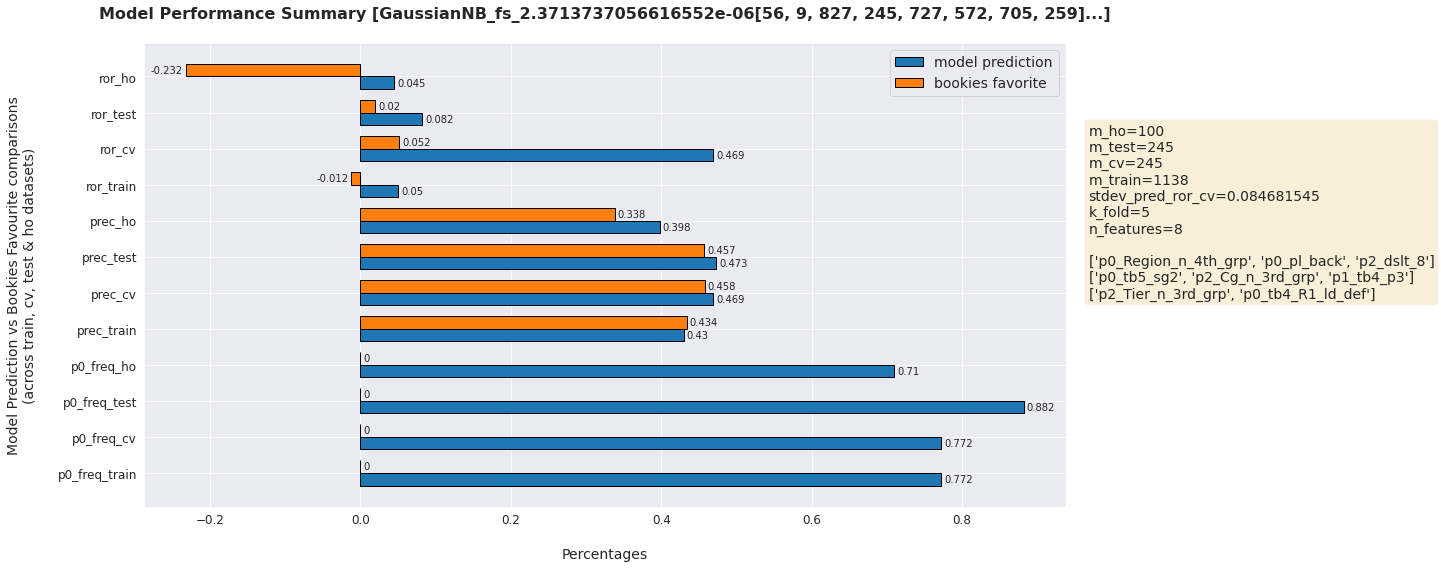

In [ ]:
df_bar = make_bars_all(best_mod, df_results, k_fold)

In [ ]:
#Review ho results from best fs model
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
import ast, pickle

#Load model and normalization parameters
loaded_model = pickle.load(open(filename_best, 'rb'))  
#loaded_model = pickle.load(open('svm_ror_PGA_R1_3b_all_data.sav', 'rb')) 
mu = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='GaussianNB_fs_2.3713737056616552e-06[56, 9, 827, 245, 727, 572, 705, 259]', 'mu'])[0])
sigma = ast.literal_eval(list(df_results.loc[df_results['prod_mod']=='GaussianNB_fs_2.3713737056616552e-06[56, 9, 827, 245, 727, 572, 705, 259]', 'sigma'])[0])
X_ho, Y_ho, df_init_ho = X_ho_df[selected_cols].copy().values, Y_ho_df.copy().values, ho_data.copy()
#Normalize data
eval_norm = np.divide(np.subtract(X_ho, mu), sigma)
#Predict from loaded model & evaluate
eval_pred = loaded_model.predict(eval_norm)
eval_ror_loaded = calc_ror(Y_ho.astype('int'), eval_pred, df_init_ho, p_res=1)
print(f'\neval_ror_loaded = {eval_ror_loaded}')

L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1, odds=[2.4 2.96 3.65], ['patrick cantlay', 'louis oosthuizen', 'sungjae im', '2021_6_17_v0_d1_grp35_PGA']
W y_true=[1. 1. 0.], y_pred=[1. 0. 0.], prof=-0.8799999999999999, odds=[2.24 3.25 3.7], ['cameron smith', 'matt jones', 'brendan steele', '2021_6_17_v0_d1_grp36_PGA']
L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-1.88, odds=[2.68 3.0 3.05], ['charley hoffman', 'kevin streelman', 'branden grace', '2021_6_17_v0_d1_grp37_PGA']
W y_true=[1. 0. 1.], y_pred=[1. 0. 0.], prof=-1.6199999999999999, odds=[2.52 3.0 3.45], ['carlos ortiz', 'lanto griffin', 'zach johnson', '2021_6_17_v0_d1_grp38_PGA']
L y_true=[0. 1. 0.], y_pred=[1. 0. 0.], prof=-2.62, odds=[2.26 3.35 3.5], ['sam burns', 'thomas detry', 'chan kim', '2021_6_17_v0_d1_grp39_PGA']
L y_true=[0. 0. 1.], y_pred=[1. 0. 0.], prof=-3.62, odds=[2.66 2.72 3.75], ['brendon todd', 'sebastian munoz', 'rikuya hoshino', '2021_6_17_v0_d1_grp40_PGA']
W y_true=[1. 0. 0.], y_pred=[1. 0. 0.], prof=-2.42

In [ ]:
type(loaded_model)

sklearn.naive_bayes.GaussianNB